# Synthetic paleomagnetic APWPs inverted using `bayesian_pep` approach

The code is a PyMC3 implementation of the paleomagnetic Euler pole inversion method first developed in PyMC2 within Ian Rose's mcplates package: https://github.com/ian-r-rose/mcplates

The functions are within the `bayesian_pep` library which is imported below.

In [1]:
from bayesian_pep import *
# theano.config.floatX = 'float64'
import seaborn as sns

d2r = np.pi/180
r2d = 180/np.pi
eps = 1.e-6
%config InlineBackend.figure_format = 'retina'

## One Euler pole inversion with minimal age uncertainty

### generate synthetic poles

In [2]:
start_age = 100
end_age = 0
number_of_poles = 5
euler_pole = [0,0]
euler_rate = 1
pole_a95 = 4
start_pole = [24, 19]

one_euler_data = generate_APWP_poles(number_of_poles, start_pole, start_age, end_age, euler_pole, euler_rate, pole_a95)
one_euler_data

pole_lon   pole_lat  pole_age  pole_a95
0   24.000000  19.000000     100.0       4.0
1   13.724333  27.231977      75.0       4.0
2  359.854182  30.256654      50.0       4.0
3  346.026499  27.112309      25.0       4.0
4  335.843743  18.796033       0.0       4.0

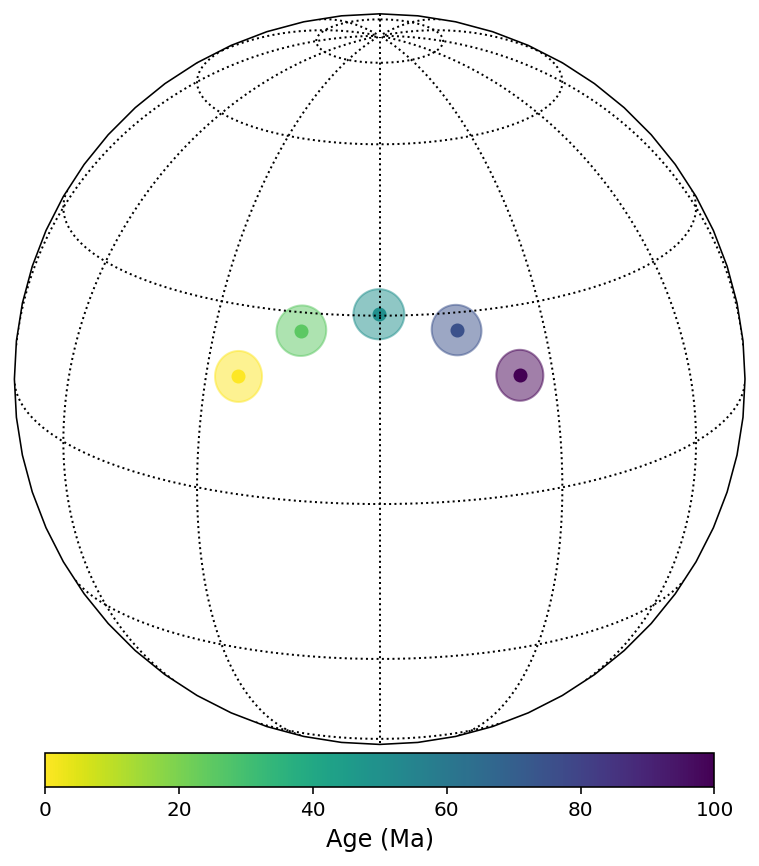

In [3]:
plot_paleomagnetic_poles(one_euler_data, central_latitude=20, add_land=0);

### invert for the Euler poles and Euler rates

In [4]:
with pm.Model() as model:
    
    #set the Euler pole position prior to be a uniform distribution (i.e. a Watson girdle with a very low k)
    euler_1 = Watson_Girdle('euler_1', lon_lat = [1.,1.,], k = -0.1, testval = np.array([1., 1.]), shape = 2)
    #set the Euler pole rate prior to be a uniform distribution between 0 and 4
    rate_1 = pm.Uniform('rate_1', 0, 4) 
    
    #set the the start age to be a tight normal distribution about the oldest pole age
    start_age = pm.Normal('start_pole_age', mu=one_euler_data['pole_age'].max(), sigma=0.01)
    print('starting pole age is: ', str(one_euler_data['pole_age'].max()))
    
    #set the start point of the path to be associated with the oldest paleomagnetic pole
    start_index = one_euler_data['pole_age'].argmax()
    start_lon_lat = [one_euler_data['pole_lon'].tolist()[start_index], one_euler_data['pole_lat'].tolist()[start_index]]
    start_k = kappa_from_two_sigma(one_euler_data['pole_a95'].tolist()[start_index])
    start = VMF('start_pole', lon_lat=start_lon_lat, 
                k = start_k, testval = np.array([1., 1.]), shape = 2)
    print('starting pole lon/lat:', start_lon_lat, 'starting pole k: ',start_k)
    
    #create the Fisher distributions associated with the observed pole positions 
    for j in range(one_euler_data.shape[0]-1):
        i = j + 1
        age = pm.Normal('t'+str(i), mu=one_euler_data['pole_age'][i], sigma=0.01)
        print('pole '+str(i)+' age: ',one_euler_data['pole_age'][i])
        
        lon_lat = pole_position_1e(start, euler_1, rate_1, start_age, age)

        observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(one_euler_data['pole_a95'].tolist()[i]), 
                            observed=[one_euler_data['pole_lon'].tolist()[i], one_euler_data['pole_lat'].tolist()[i]])
        
    #uncomment to run the model
    #trace_1e = pm.sample(100000, step = pm.Metropolis(), chains=1, init='auto')

starting pole age is:  100.0
starting pole lon/lat: [24.0, 19.0] starting pole k:  1225.0
pole 1 age:  75.0
pole 2 age:  50.0
pole 3 age:  25.0
pole 4 age:  0.0


In [5]:
# pm.save_trace(trace_1e, 'code_output/1_euler_trace', overwrite=1)

In [6]:
trace_1e_saved = pm.load_trace('code_output/1_euler_trace',model)

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


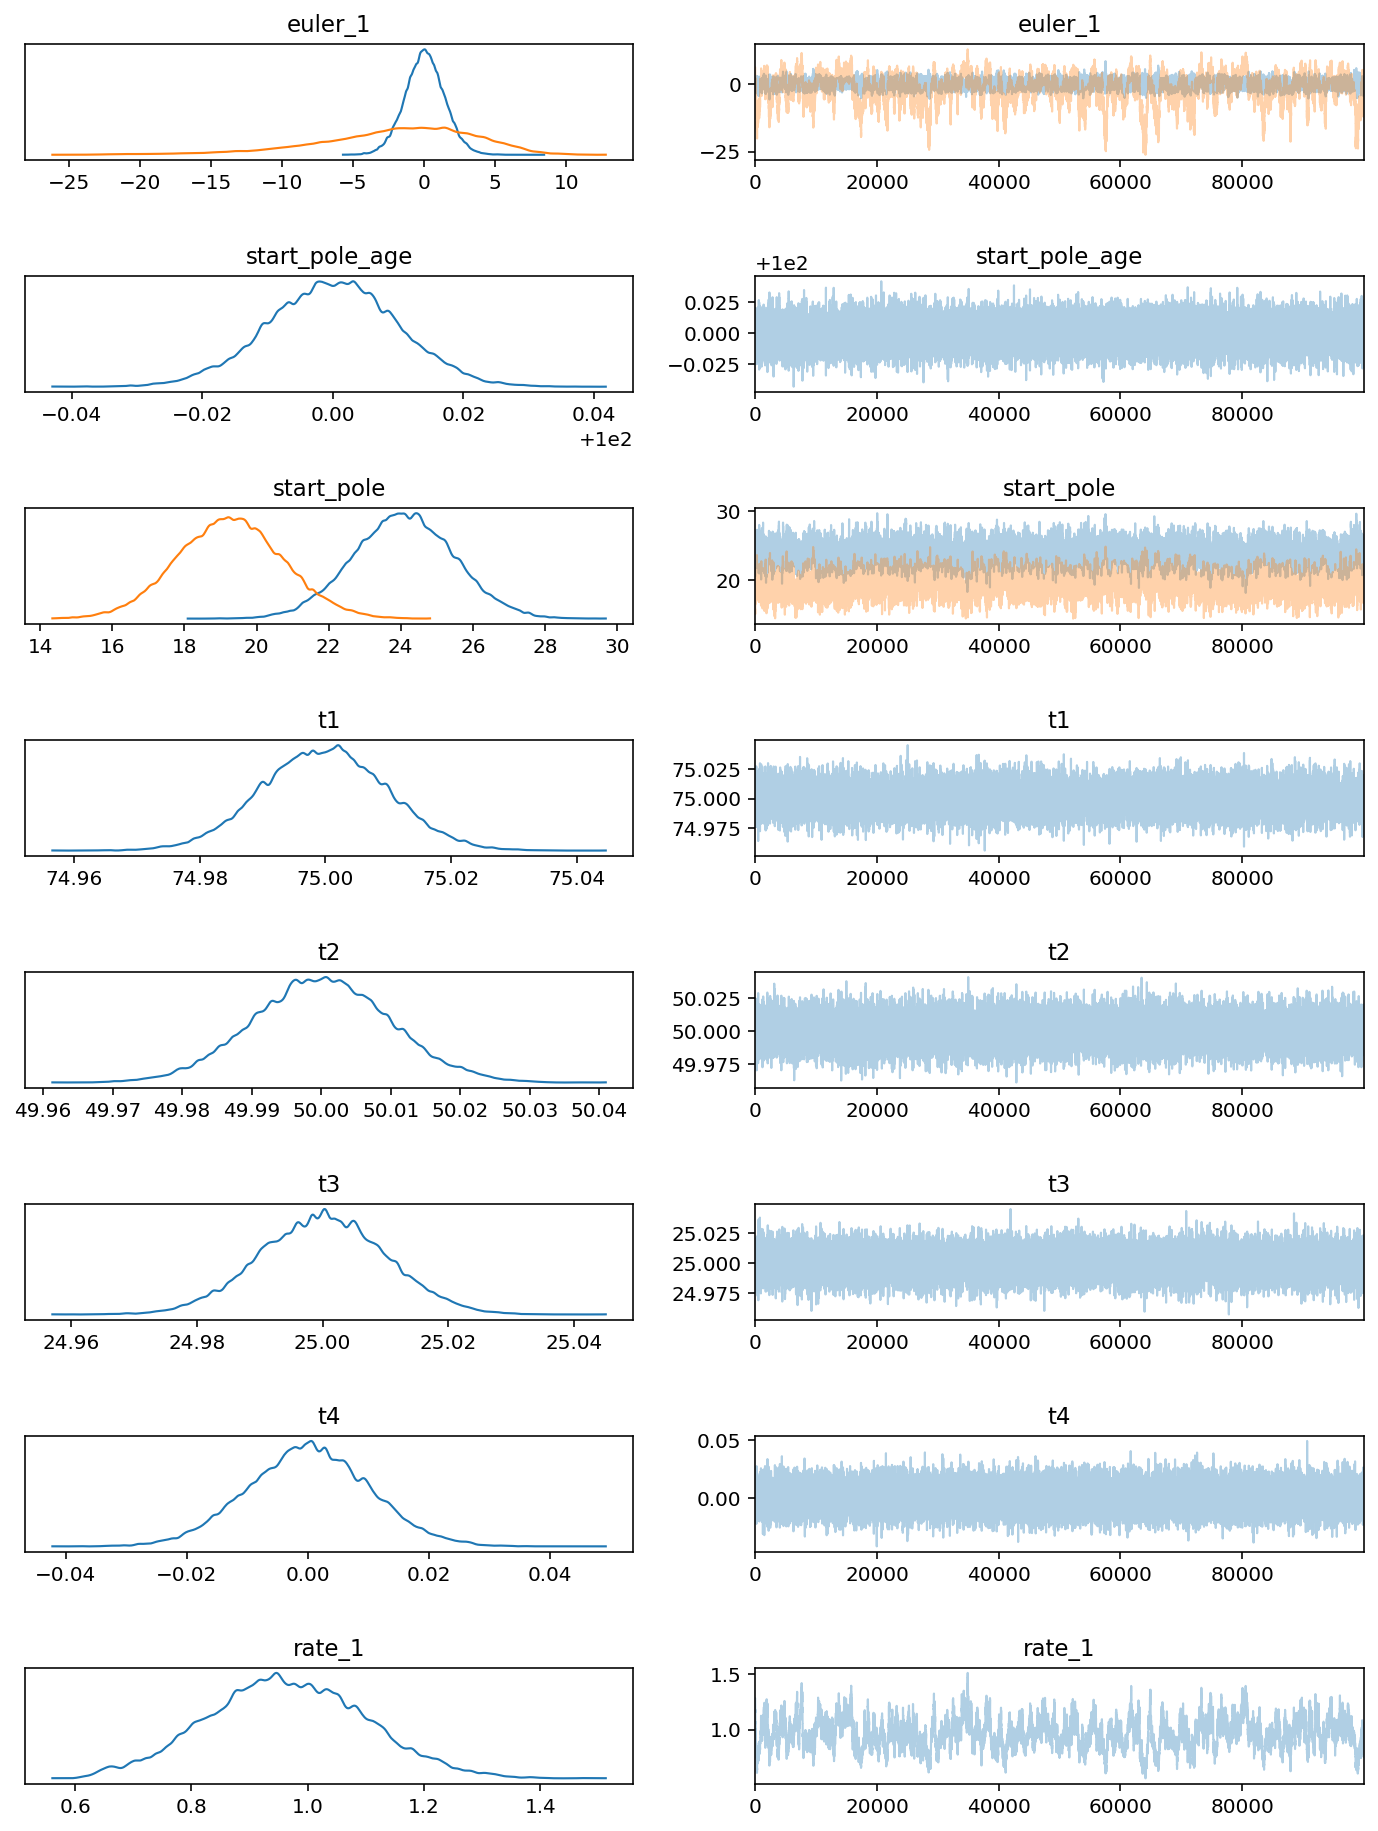

In [7]:
axes = pm.traceplot(trace_1e_saved, compact=1)
plt.subplots_adjust(hspace = 1)
# plt.savefig('code_output/1_euler_inversion_traceplot.pdf', bbox_inches='tight')

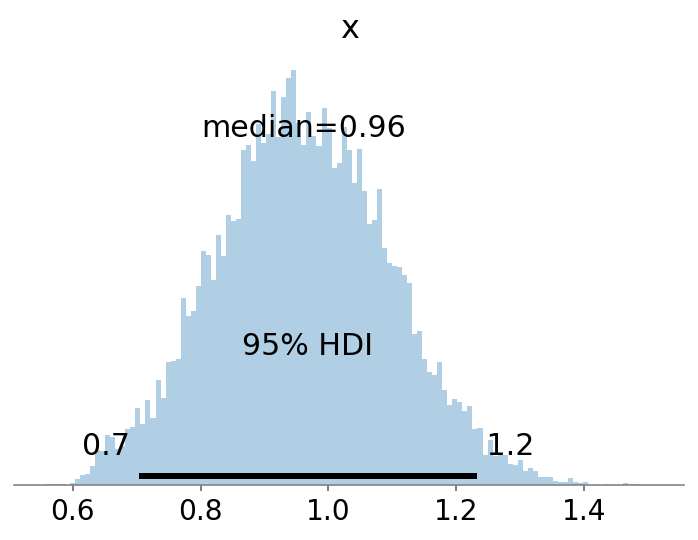

In [7]:
az.plot_posterior(trace_1e_saved['rate_1'],kind='hist',point_estimate='median',hdi_prob=0.95)
plt.show()

0.9611758891239083 0.7036047937759307 1.2325747400942728


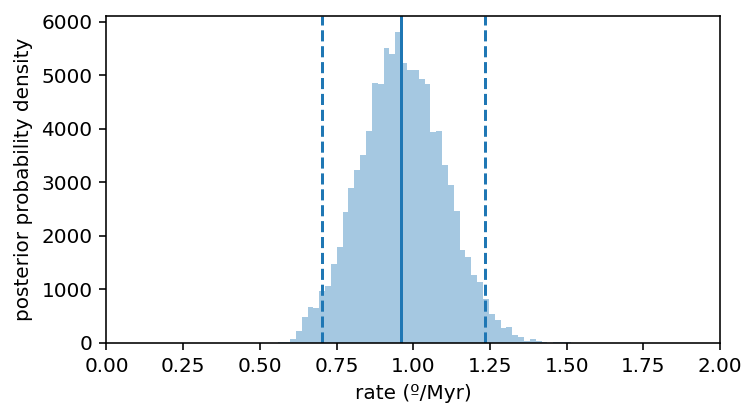

In [98]:
HPD_max = np.percentile(trace_1e_saved['rate_1'],97.5)
HPD_min = np.percentile(trace_1e_saved['rate_1'],2.5)
median = np.median(trace_1e_saved['rate_1'])
print(median, HPD_min, HPD_max)

plt.figure(figsize=(5.5,3))
sns.distplot(trace_1e_saved['rate_1'],kde=False)
plt.axvline(x=median)
plt.axvline(x=HPD_min,linestyle='--')
plt.axvline(x=HPD_max,linestyle='--')
plt.xlabel('rate (º/Myr)')
plt.ylabel('posterior probability density')
plt.xlim(0,2)
plt.savefig('code_output/1_Euler_inversion_rate.png',dpi=600,bbox_inches='tight')

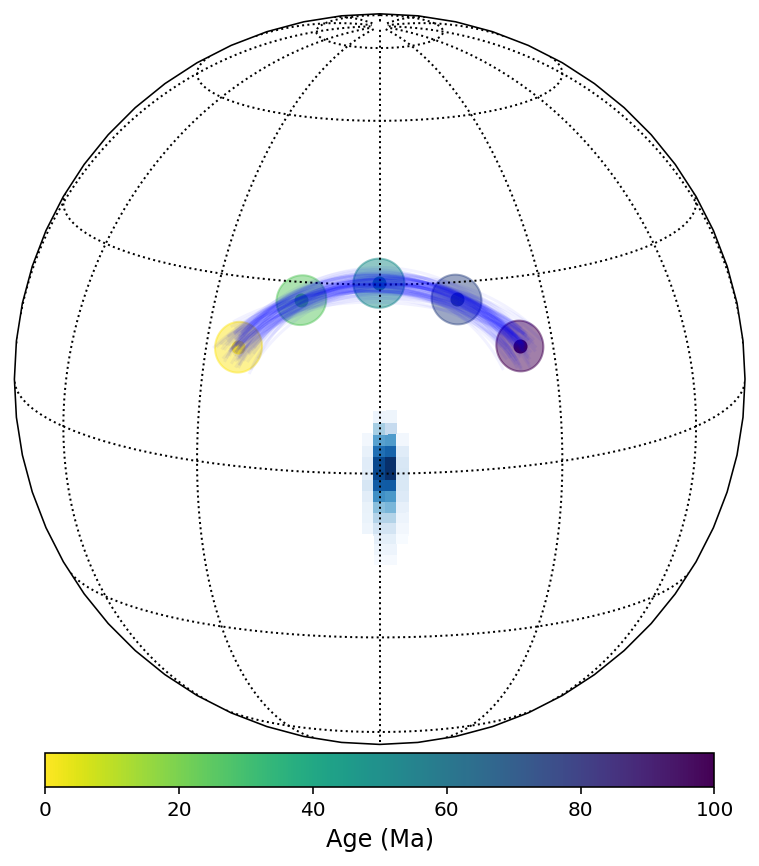

In [14]:
plot_trace_1e(trace_1e_saved, one_euler_data[['pole_lon', 'pole_lat']].to_numpy(), one_euler_data['pole_a95'], one_euler_data['pole_age'].tolist(), 
              central_lon=0, central_lat=15, num_paths_to_plot=100, cmap='Blues',
              savefig = True, figname = 'code_output/1_Euler_inversion.png');

## Two Euler pole inversion

### generate synthetic poles

In [2]:
start_age = 120
end_age = 60
number_of_poles = 5
euler_pole = [0,-10]
euler_rate = 1.5
pole_a95 = 4
start_pole = [30, -5]

two_euler_data_1 = generate_APWP_poles(number_of_poles, start_pole, start_age, end_age, euler_pole, euler_rate, pole_a95)

start_age = 60
end_age = 0
number_of_poles = 5
euler_pole = [-60,10]
euler_rate = .75
pole_a95 = 4
start_pole = [two_euler_data_1['pole_lon'][4], two_euler_data_1['pole_lat'][4]]

two_euler_data_2 = generate_APWP_poles(number_of_poles, start_pole, start_age, end_age, euler_pole, euler_rate, pole_a95)
two_euler_data = pd.concat([two_euler_data_1,two_euler_data_2[1:]])
two_euler_data.reset_index(inplace=True)
two_euler_data

index    pole_lon   pole_lat  pole_age  pole_a95
0      0   30.000000  -5.000000     120.0       4.0
1      1   25.957841   5.495399     105.0       4.0
2      2   18.439918  13.960144      90.0       4.0
3      3    7.999308  19.095230      75.0       4.0
4      4  356.098440  19.899208      60.0       4.0
5      1  355.203027  29.057709      45.0       4.0
6      2  352.832034  38.038463      30.0       4.0
7      3  348.362466  46.623101      15.0       4.0
8      4  340.690169  54.431584       0.0       4.0

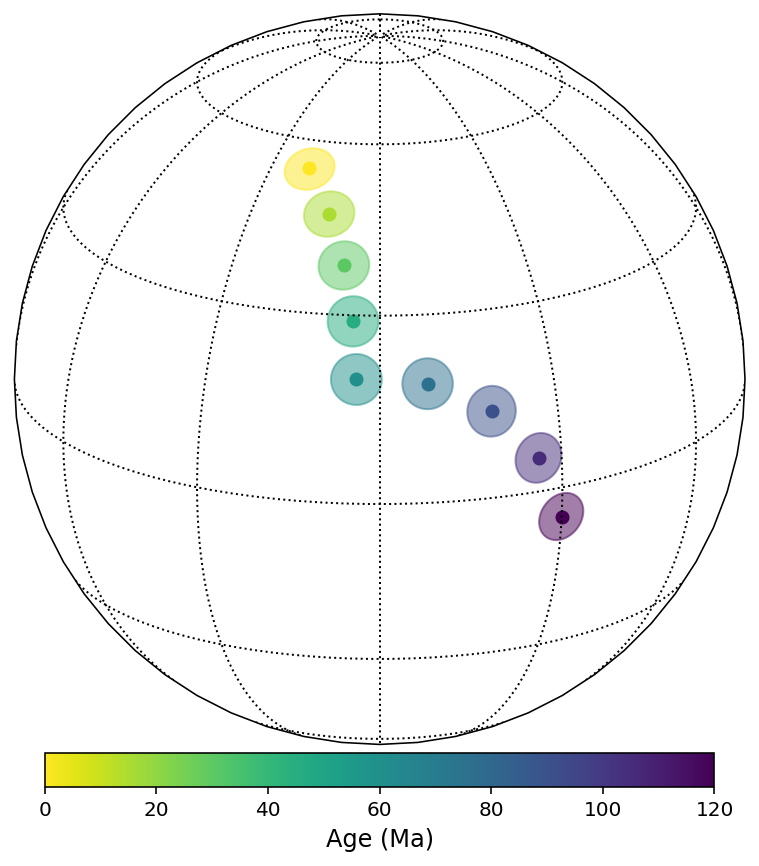

In [3]:
plot_paleomagnetic_poles(two_euler_data, central_latitude=20, add_land=0);

In [4]:
with pm.Model() as model:

    euler_1 = Watson_Girdle('euler_1', lon_lat = [1.,0.,], k = -0.1, testval = np.array([1., 0.]), shape = 2)
    rate_1 = pm.Uniform('rate_1', 0.0, 4.0)  
    euler_2 = Watson_Girdle('euler_2', lon_lat = [1.,0.,], k = -0.1, testval = np.array([1., 0.]), shape = 2)
    rate_2 = pm.Uniform('rate_2', 0.0, 4.0) 
    
    start_age = pm.Normal('start_pole_age', two_euler_data['pole_age'].max(), 0.01)
    print('starting pole age is: ', str(two_euler_data['pole_age'].max()))
    
    start_index = two_euler_data['pole_age'].argmax()
    
    start_lon_lat = [two_euler_data['pole_lon'].tolist()[start_index], two_euler_data['pole_lat'].tolist()[start_index]]
    start_k = kappa_from_two_sigma(two_euler_data['pole_a95'].tolist()[start_index])
    
    start = VMF('start_pole', lon_lat=start_lon_lat, 
                k = start_k, testval = np.array(start_lon_lat), shape = 2)
    
    switchpoint = pm.Uniform('switchpoint', two_euler_data['pole_age'].min(), two_euler_data['pole_age'].max())

    for i in range(two_euler_data.shape[0]):
        
        age = pm.Normal('t'+str(i), mu=two_euler_data['pole_age'][i], sigma=0.01)
        print('pole '+str(i)+' age: ',two_euler_data['pole_age'][i])
        
        lon_lat = pole_position_2e(start, euler_1, rate_1, euler_2, rate_2, switchpoint, start_age, age)

        observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(two_euler_data['pole_a95'].tolist()[i]), 
                            observed=[two_euler_data['pole_lon'].tolist()[i], two_euler_data['pole_lat'].tolist()[i]])
        
    trace_2e = pm.sample(25000, step = pm.Metropolis(), compute_convergence_checks=1, chains=1, cores=1)

starting pole age is:  120.0
pole 0 age:  120.0
pole 1 age:  105.0
pole 2 age:  90.0
pole 3 age:  75.0
pole 4 age:  60.0
pole 5 age:  45.0
pole 6 age:  30.0
pole 7 age:  15.0
pole 8 age:  0.0


Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [t8]
>Metropolis: [t7]
>Metropolis: [t6]
>Metropolis: [t5]
>Metropolis: [t4]
>Metropolis: [t3]
>Metropolis: [t2]
>Metropolis: [t1]
>Metropolis: [t0]
>Metropolis: [switchpoint]
>Metropolis: [start_pole]
>Metropolis: [start_pole_age]
>Metropolis: [rate_2]
>Metropolis: [euler_2]
>Metropolis: [rate_1]
>Metropolis: [euler_1]


Sampling 1 chain for 1_000 tune and 25_000 draw iterations (1_000 + 25_000 draws total) took 1335 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [5]:
pm.save_trace(trace_2e, 'code_output/2_euler_trace', overwrite=1)

'code_output/2_euler_trace'

In [6]:
trace_2e_saved = pm.load_trace('code_output/2_euler_trace',model)[5000:]

In [7]:
# plt.figure(figsize=(10, 20))
axes = pm.traceplot(trace_2e_saved, compact=1)
plt.subplots_adjust(hspace = 1 )
plt.savefig('code_output/2_euler_inversion_traceplot.pdf', bbox_inches='tight')

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


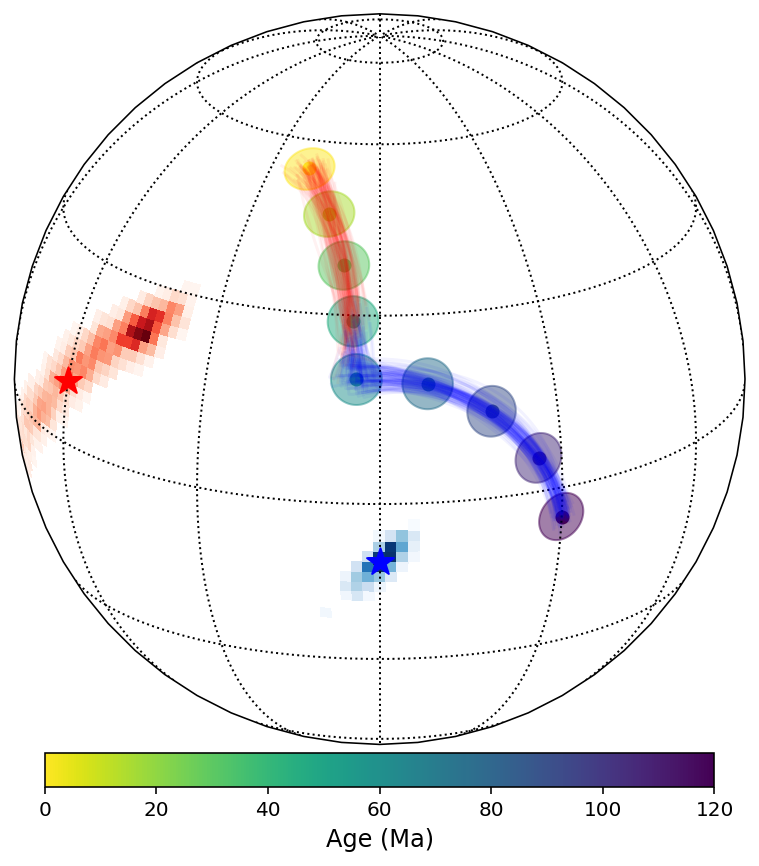

In [14]:
two_euler_ax = plot_trace_2e(trace_2e_saved, two_euler_data[['pole_lon', 'pole_lat']].to_numpy(), two_euler_data['pole_a95'], two_euler_data['pole_age'].tolist(), 
              0, 20, 100, savefig=0, figname='code_output/2_Euler_inversion.png')
ipmag.plot_vgp(two_euler_ax, 0,-10, marker='*', color = 'blue', edge='blue',markersize=200)
ipmag.plot_vgp(two_euler_ax, -60,10, marker='*', color = 'red', edge='red',markersize=200)
plt.savefig('code_output/2_Euler_inversion.png', dpi=600, bbox_inches='tight')

In [16]:
HPD_max_1 = np.percentile(trace_2e_saved['rate_1'],97.5)
HPD_min_1 = np.percentile(trace_2e_saved['rate_1'],2.5)
median_1 = np.median(trace_2e_saved['rate_1'])
print(median_1, HPD_min_1, HPD_max_1)

HPD_max_2 = np.percentile(trace_2e_saved['rate_2'],97.5)
HPD_min_2 = np.percentile(trace_2e_saved['rate_2'],2.5)
median_2 = np.median(trace_2e_saved['rate_2'])
print(median_2, HPD_min_2, HPD_max_2)

plt.figure(figsize=(5.5,3))
sns.distplot(trace_2e_saved['rate_1'],kde=False, bins=20)
sns.distplot(trace_2e_saved['rate_2'],kde=False,  bins=20)

plt.axvline(x=median_1)
plt.axvline(x=HPD_min_1,linestyle='--')
plt.axvline(x=HPD_max_1,linestyle='--')

plt.axvline(x=median_2, color = 'C1')
plt.axvline(x=HPD_min_2,linestyle='--', color = 'C1')
plt.axvline(x=HPD_max_2,linestyle='--', color = 'C1')

plt.xlabel('rate (º/Myr)')
plt.ylabel('posterior probability density')
plt.xlim(0,2)
plt.savefig('code_output/2_Euler_inversion_rate.png',dpi=600,bbox_inches='tight')

1.4545616185911183 1.0718225776103885 1.7985923513156217
0.7620591143571274 0.570397947776368 1.2404647576082488


## Generate figure of synthetic 1 and 2 Euler inversions

In [17]:
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.image as mpimg

one_euler_map_img = mpimg.imread('code_output/1_Euler_inversion.png')
one_euler_rate_img = mpimg.imread('code_output/1_Euler_inversion_rate.png')

two_euler_map_img = mpimg.imread('code_output/2_Euler_inversion.png')
two_euler_rate_img = mpimg.imread('code_output/2_Euler_inversion_rate.png')


fig = plt.figure(figsize=(15., 15.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [one_euler_map_img,
                         two_euler_map_img,
                         one_euler_rate_img,
                         two_euler_rate_img]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
    ax.axis("off")


plt.subplots_adjust(wspace=0.2, hspace=0)

plt.savefig('./code_output/fig_synthetic_pep.png',dpi=600,bbox_inches='tight')
plt.show()

## One Euler pole inversion with various age constraints

### generate synthetic poles

In [18]:
start_age = 140
end_age = 40
number_of_poles = 5
euler_pole = [0,0]
euler_rate = 1
pole_a95 = 4
start_pole = [24, 19]

one_euler_age_data = generate_APWP_poles(number_of_poles, start_pole, start_age, end_age, euler_pole, euler_rate, pole_a95)
one_euler_age_data['pole_age'] = [140., None, None, None, 40.]
one_euler_age_data['age_sigma'] = [5., None, None, None, 5.]
one_euler_age_data

pole_lon   pole_lat  pole_age  pole_a95  age_sigma
0   24.000000  19.000000     140.0       4.0        5.0
1   13.724333  27.231977       NaN       4.0        NaN
2  359.854182  30.256654       NaN       4.0        NaN
3  346.026499  27.112309       NaN       4.0        NaN
4  335.843743  18.796033      40.0       4.0        5.0

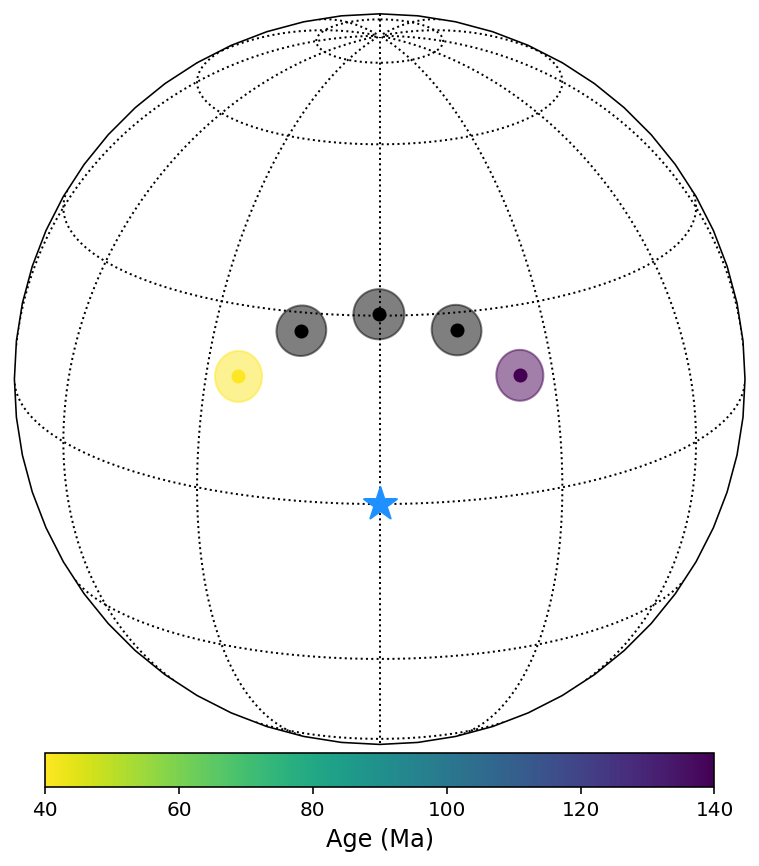

In [20]:
age_uncertainty_ax = plot_paleomagnetic_poles(one_euler_age_data, central_latitude=20, add_land=0)
ipmag.plot_vgp(age_uncertainty_ax, 0,0, marker='*', color = 'dodgerblue', edge='dodgerblue',markersize=300)
plt.savefig('code_output/1_euler_prior_poles.png', dpi=600, bbox_inches='tight')

### generate pole age prior distributions

In [4]:
def get_age_boundaies(ages, age_sigmas):
    real_ages = []
    real_sigma = []
    for i in range(len(ages)):
        if np.isnan(age_sigmas[i]) == 0  :
            real_ages.append(ages[i])
            real_sigma.append(age_sigmas[i])
#     print(real_ages)      
    age_upper = max(real_ages)+3*age_sigmas[np.argmax(real_sigma)]
    age_lower = min(real_ages)-3*age_sigmas[np.argmin(real_sigma)]
    return max(real_ages), min(real_ages), age_upper, age_lower

def plot_age_prior(ages, age_sigmas, **kwargs):

    age_max, age_min, age_upper, age_lower = get_age_boundaies(ages, age_sigmas)
    
    print(age_upper, age_lower)
    fig, ax = plt.subplots(figsize=(6, 3))

    cNorm  = matplotlib.colors.Normalize(vmin=age_min, vmax=age_max)
    scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap='viridis_r')

    color_list = [colors.rgb2hex(scalarMap.to_rgba(ages[i])) for i in range(len(ages))]

#     cbar = plt.colorbar(scalarMap, shrink=0.85)
#     cbar.ax.set_xlabel('Age (Ma)', fontsize=12)                               
    max_y = 0
                                       
    for i in range(len(ages)):
        this_age = ages[i]
        this_age_sigma = age_sigmas[i]


        if np.isnan(this_age_sigma) == 1:
            # this means we do not know the age of the pole except it is between the min and max age of the list

            x = np.linspace(age_lower, age_upper, 500)
            y = np.zeros(500)
            y[(x< age_upper) & (x>age_lower)] = 1.0/(age_upper-age_lower)

            color_list[i] = 'grey'
            if max_y < max(y):
                max_y = max(y)
                                       
        else:
            mu = this_age
            sigma = this_age_sigma

            x = np.linspace(mu-3*sigma,mu+3*sigma, 1000)
            y = st.norm.pdf(x, mu, sigma)
            if max_y < max(y):
                max_y = max(y)
        ax.plot(x, y, color = color_list[i], lw=1)
        ax.fill_between(x, y, color = color_list[i], alpha = 0.2)
        
    ax.grid(ls='--')
    ax.set_xlim(age_lower*0.9, age_upper+age_lower*0.1)
    ax.set_ylim(0, max_y*1.1)
    ax.set_ylabel('Probability density')
    ax.set_xlabel('Age (Ma)')
#     ax.set_title('Prior distributions assigned to age of poles', fontdict={'fontsize':14})
    
    return ax

In [5]:
plot_age_prior(one_euler_age_data['pole_age'].tolist(), one_euler_age_data['age_sigma'].tolist())
# plt.savefig('code_output/1_euler_prior_ages.png', dpi=600, bbox_inches='tight')

155.0 25.0


<AxesSubplot:xlabel='Age (Ma)', ylabel='Probability density'>

### invert for the Euler poles and Euler rates

In [6]:
with pm.Model() as model:
    
    _, _ , age_upper, age_lower = get_age_boundaies(one_euler_age_data['pole_age'].tolist(), one_euler_age_data['age_sigma'].tolist())
    print('upper age bound: ', age_upper, 'lower age bound: ', age_lower)
    
    euler_1 = Watson_Girdle('euler_1', lon_lat = [1.,1.,], k = -1., testval = np.array([1., 1.]), shape = 2)
    rate_1 = pm.Uniform('rate_1', 0, 4) 
    
    start_age = pm.Normal('start_pole_age', one_euler_age_data['pole_age'].max(), 0.1)
    print('starting pole age is: ', str(one_euler_age_data['pole_age'].max()))
    
    start_index = one_euler_age_data['pole_age'].argmax()
    
    start_lon_lat = [one_euler_age_data['pole_lon'].tolist()[start_index], one_euler_age_data['pole_lat'].tolist()[start_index]]
    start_k = kappa_from_two_sigma(one_euler_age_data['pole_a95'].tolist()[start_index])
    
    start = VMF('start_pole', lon_lat=start_lon_lat, 
                k = start_k, testval = np.array([1., 1.]), shape = 2)
    
    print('starting pole lon/lat:', start_lon_lat, 'starting pole k: ',start_k)
    
    
    for i in range(one_euler_age_data.shape[0]):
        if np.isnan(one_euler_age_data['age_sigma'][i]) == 1:
            # uniform
            age = pm.Uniform('t'+str(i), age_lower, age_upper)
            print('pole '+str(i)+' age: ', age_lower, '-', age_upper)
        else: 
            age = pm.Normal('t'+str(i), mu=one_euler_age_data['pole_age'][i], sigma=one_euler_age_data['age_sigma'][i])
            
            print('pole '+str(i)+' age: ',one_euler_age_data['pole_age'][i], u"\u00B1", one_euler_age_data['age_sigma'][i])
        
        lon_lat = pole_position_1e(start, euler_1, rate_1, start_age, age)

        observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(one_euler_age_data['pole_a95'].tolist()[i]), 
                            observed=[one_euler_age_data['pole_lon'].tolist()[i], one_euler_age_data['pole_lat'].tolist()[i]])
        
#     trace_1e_age = pm.sample(10000, step = pm.Metropolis(), compute_convergence_checks=1, chains=1, cores=1, init='auto')

upper age bound:  155.0 lower age bound:  25.0
starting pole age is:  140.0
starting pole lon/lat: [24.0, 19.0] starting pole k:  1225.0
pole 0 age:  140.0 ± 5.0
pole 1 age:  25.0 - 155.0
pole 2 age:  25.0 - 155.0
pole 3 age:  25.0 - 155.0
pole 4 age:  40.0 ± 5.0


In [145]:
# pm.save_trace(trace_1e_age, 'code_output/1_euler_age_trace', overwrite=1)

'code_output/1_euler_age_trace'

In [21]:
trace_1e_age_saved = pm.load_trace('code_output/1_euler_age_trace',model)

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


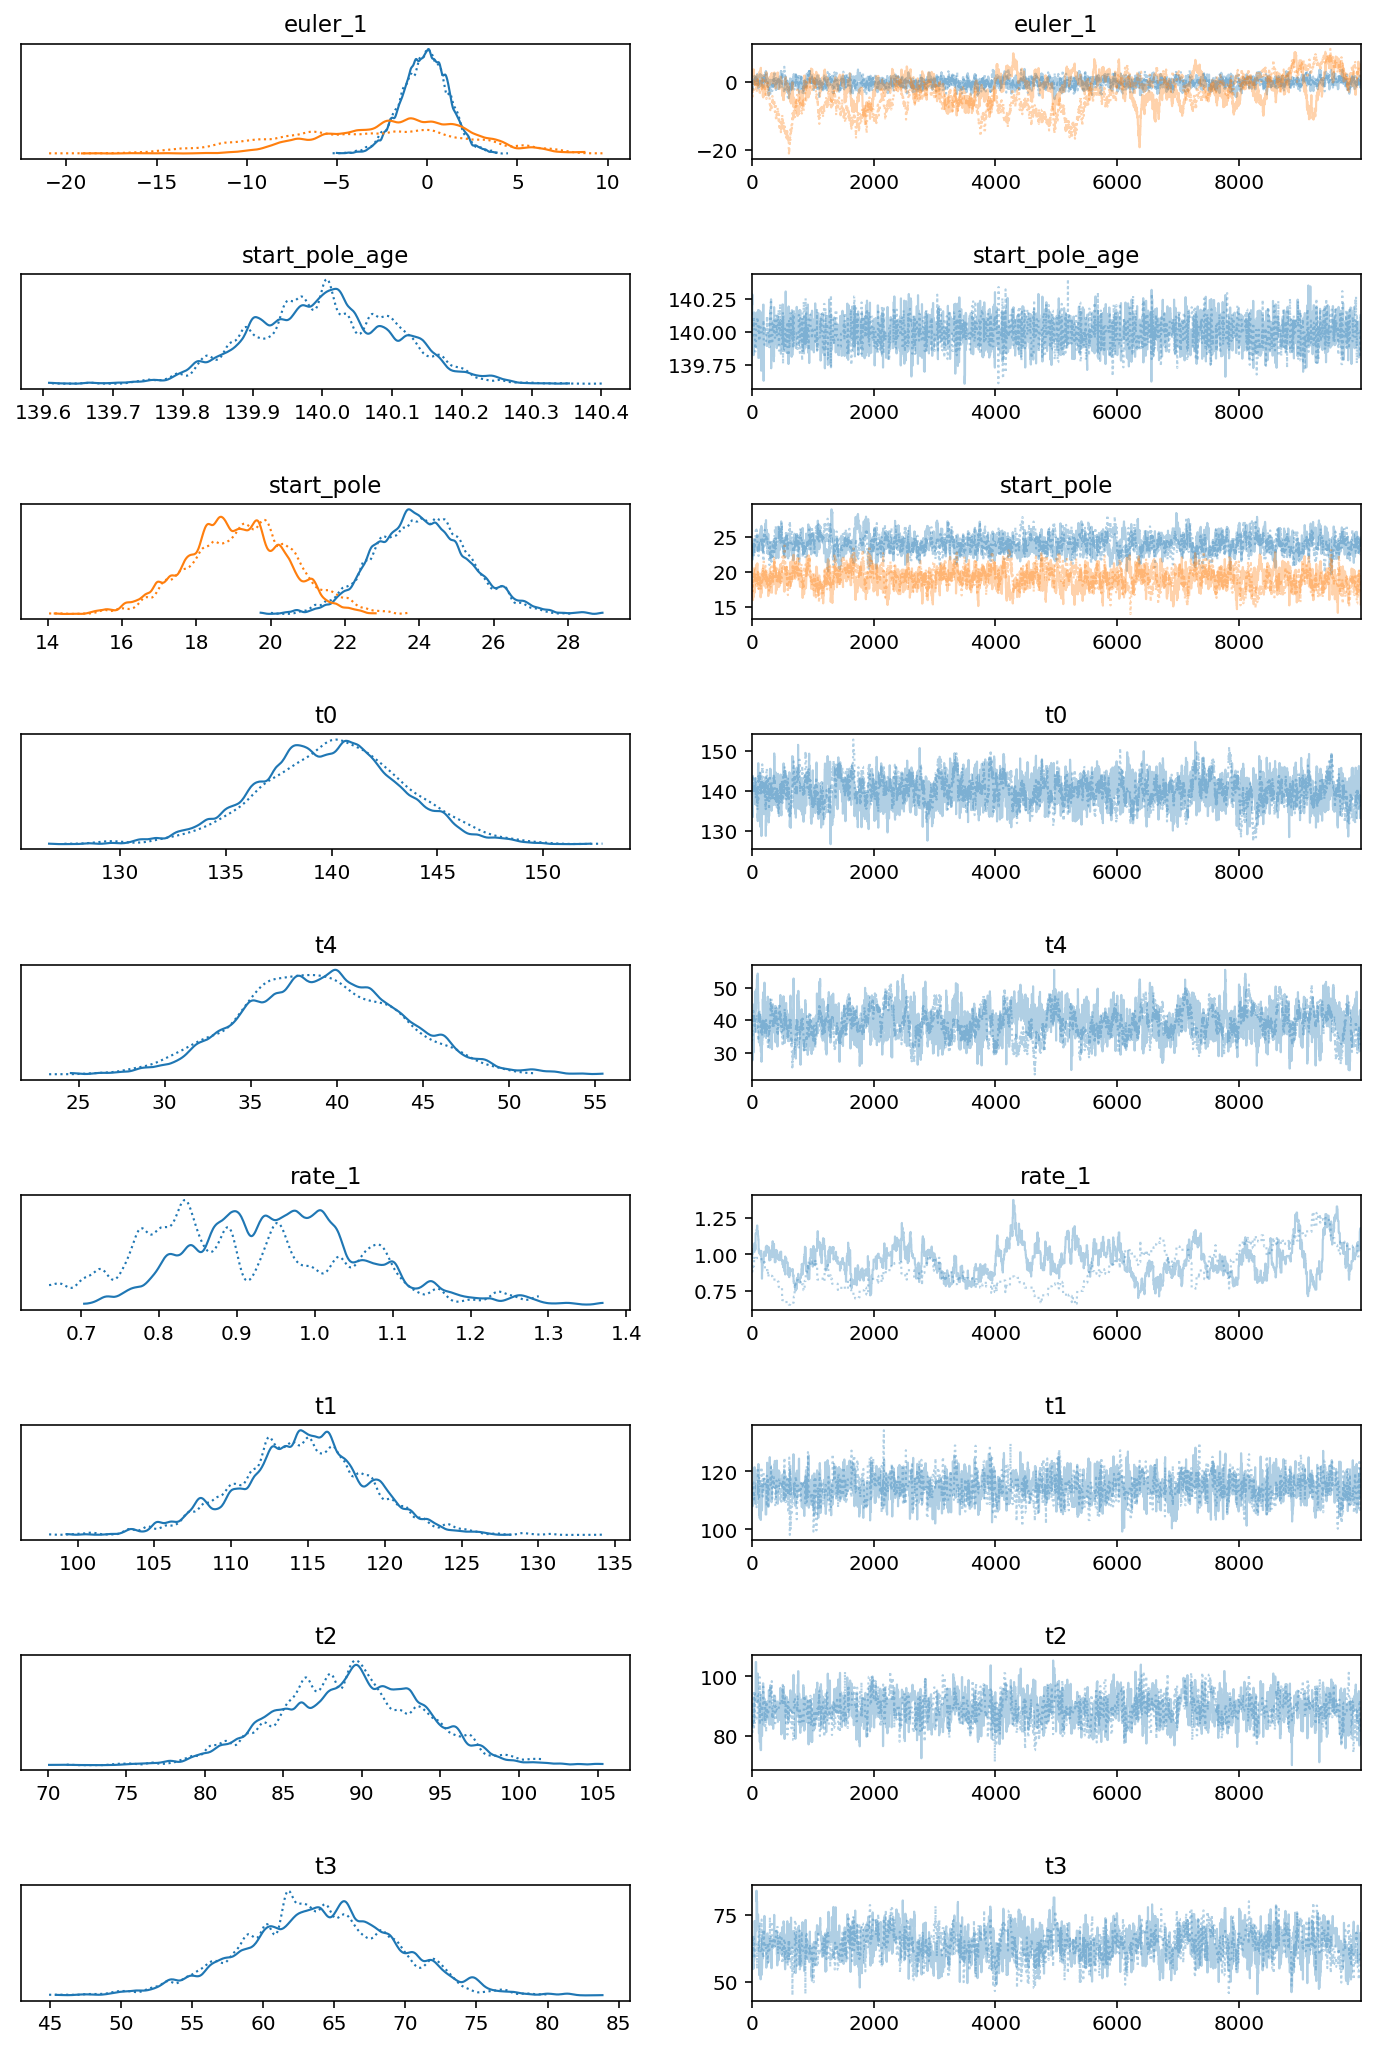

In [144]:
# plt.figure(figsize=(10, 20))
axes = pm.traceplot(trace_1e_age_saved, compact=1)
plt.subplots_adjust(hspace = 1 )
plt.savefig('code_output/1_euler_age_inversion_traceplot.pdf', bbox_inches='tight')

<GeoAxesSubplot:>

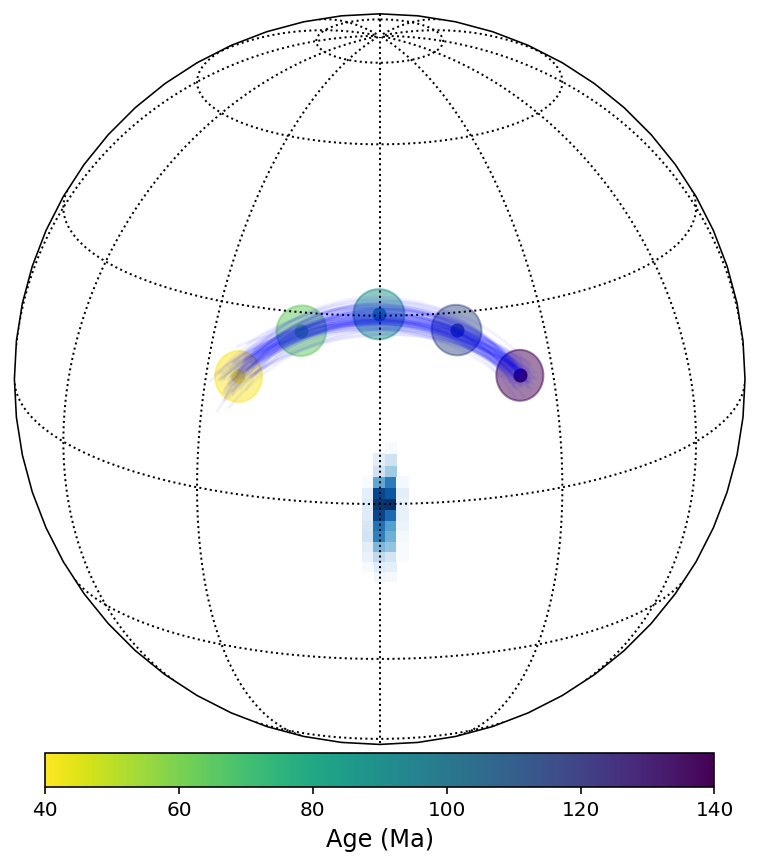

In [9]:
plot_trace_1e(trace_1e_age_saved, one_euler_age_data[['pole_lon', 'pole_lat']].to_numpy(), one_euler_age_data['pole_a95'], one_euler_age_data['pole_age'].tolist(), 
              0, 20, 100, savefig=1, figname='code_output/1_Euler_posterior_poles.png', estimate_pole_age=1, cmap='Blues')

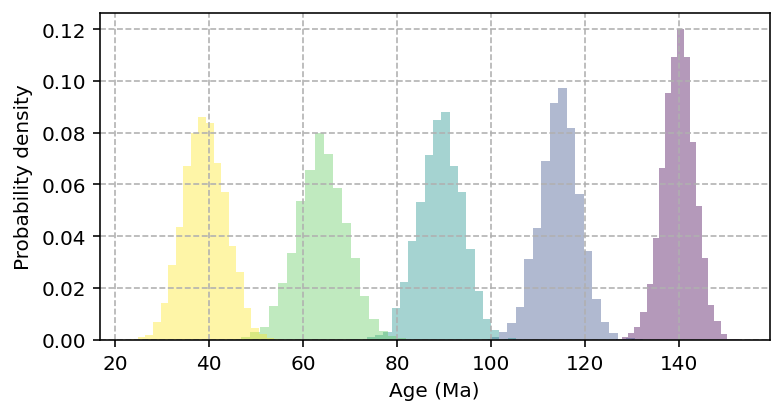

In [24]:
plt.figure(figsize=(6, 3))

cNorm  = matplotlib.colors.Normalize(vmin=min(one_euler_age_data['pole_age']), vmax=max(one_euler_age_data['pole_age']))
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap='viridis_r')

pole_colors = [colors.rgb2hex(scalarMap.to_rgba(np.median(trace_1e_age_saved['t'+str(i)]))) 
               for i in range(len(one_euler_age_data['pole_age']))]

pole_age_list = ['t0', 't1', 't2', 't3', 't4']
for i in range(len(pole_age_list)):
    sns.distplot(trace_1e_age_saved[pole_age_list[i]], kde=0, norm_hist=1,  bins=20,
              color = pole_colors[i])
plt.grid(ls='--')
# plt.hist(trace_1e_age_df['t0'])
# plt.distplot(data=trace_1e_age_df['t1'])
# plt.distplot(data=trace_1e_age_df['t2'])
# plt.distplot(data=trace_1e_age_df['t3'])
# plt.distplot(data=trace_1e_age_df['t4'])
plt.ylabel('Probability density')
plt.xlabel('Age (Ma)')
plt.savefig('code_output/1_euler_posterior_ages.png', dpi=600, bbox_inches='tight')
plt.show()

## Generate figure of synthetic 1 euler inversion with prior age uncertainties

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.image as mpimg

one_euler_prior_poles_img = mpimg.imread('code_output/1_euler_prior_poles.png')
one_euler_posterior_poles_img = mpimg.imread('code_output/1_Euler_posterior_poles.png')

one_euler_prior_ages_img = mpimg.imread('code_output/1_euler_prior_ages.png')
one_euler_posterior_ages_img = mpimg.imread('code_output/1_euler_posterior_ages.png')


fig = plt.figure(figsize=(15., 15.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [one_euler_prior_poles_img,
                         one_euler_posterior_poles_img,
                         one_euler_prior_ages_img,
                         one_euler_posterior_ages_img]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
    ax.axis("off")


plt.subplots_adjust(wspace=0.2, hspace=0)

plt.savefig('./code_output/fig_inversion_with_age_uncertainties.png',dpi=600,bbox_inches='tight')
plt.show()

## One Euler and tpw inversion

### generate synthetic poles

In [18]:
start_age = 100
end_age = 0
number_of_poles = 5
euler_pole = [0,0]
euler_rate = 1
pole_a95 = 4
start_pole = [24, 19]

one_euler_data = generate_APWP_poles(number_of_poles, start_pole, start_age, end_age, euler_pole, euler_rate, pole_a95)
one_euler_data

pole_lon   pole_lat  pole_age  pole_a95
0   24.000000  19.000000     100.0       4.0
1   13.724333  27.231977      75.0       4.0
2  359.854182  30.256654      50.0       4.0
3  346.026499  27.112309      25.0       4.0
4  335.843743  18.796033       0.0       4.0

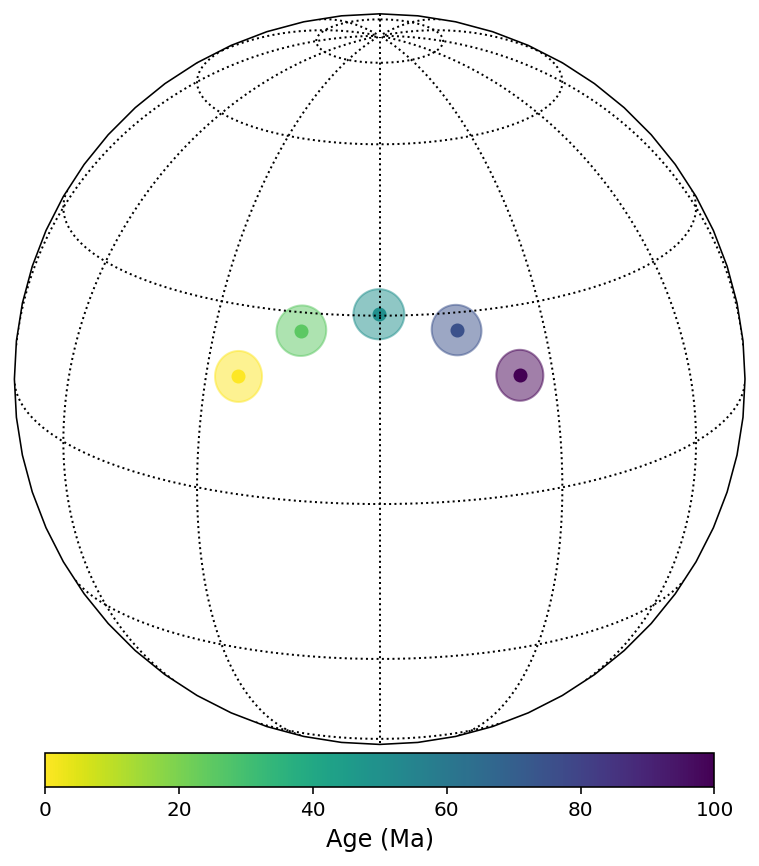

In [19]:
plot_paleomagnetic_poles(one_euler_data, central_latitude=20, add_land=0);

### invert for the Euler poles and Euler rates, tpw and tpw rates

In [79]:
@as_op(itypes=[T.dvector, T.dvector, T.dscalar, T.dscalar, T.dscalar, T.dscalar, T.dscalar], otypes=[T.dvector])
def pole_position_1e_tpw(start, euler_1, rate_1, tpw_angle, tpw_rate, start_age, age):
    
    start_pole = PaleomagneticPole(start[0], start[1], age=start_age)
    
    euler_pole_1 = EulerPole(euler_1[0], euler_1[1], rate_1)
    
    # make a TPW pole
    test_1 = np.array([0.,0.,1.])
    test_2 = np.array([1.,0.,0.])
    if np.dot(start_pole._pole, test_1) > np.dot(start_pole._pole, test_2):
        great_circle_pole = np.cross(start_pole._pole, test_2)
    else:
        great_circle_pole = np.cross(start_pole._pole, test_1)
    lon, lat, _ = cartesian_to_spherical(great_circle_pole)

    TPW = EulerPole(lon[0], lat[0], tpw_rate)
    TPW.rotate(start_pole, tpw_angle)
    
    this_euler = euler_pole_1.copy()
    this_euler.rotate(TPW, TPW.rate*(start_age-age))
    start_pole.rotate(TPW, TPW.rate*(start_age-age))
    
    start_pole.rotate(this_euler, this_euler.rate*(start_age-age))

    lon_lat = np.ndarray.flatten(np.array([start_pole.longitude, start_pole.latitude]))

    return lon_lat


def plot_trace_1e_tpw(trace, lon_lats, A95s, ages, central_lon = 30., central_lat = 30., num_paths_to_plot = 200, 
                  savefig = False, figname = 'code_output/1_Euler_inversion_.pdf', **kwargs):
    def pole_position(start, euler_1, rate_1, tpw_angle, tpw_rate, start_age, age):

        start_pole = PaleomagneticPole(start[0], start[1], age=start_age)

        euler_pole_1 = EulerPole(euler_1[0], euler_1[1], rate_1)

        # make a TPW pole
        test_1 = np.array([0.,0.,1.])
        test_2 = np.array([1.,0.,0.])
        if np.dot(start_pole._pole, test_1) > np.dot(start_pole._pole, test_2):
            great_circle_pole = np.cross(start_pole._pole, test_2)
        else:
            great_circle_pole = np.cross(start_pole._pole, test_1)
        lon, lat, _ = cartesian_to_spherical(great_circle_pole)

        TPW = EulerPole(lon[0], lat[0], tpw_rate)
        TPW.rotate(start_pole, tpw_angle)

        this_euler = euler_pole_1.copy()
        this_euler.rotate(TPW, TPW.rate*(start_age-age))
        start_pole.rotate(TPW, TPW.rate*(start_age-age))

        start_pole.rotate(this_euler, this_euler.rate*(start_age-age))

        lon_lat = np.ndarray.flatten(np.array([start_pole.longitude, start_pole.latitude]))

        return lon_lat
    
    euler_1_directions = trace.euler_1
    euler_rates_1 = trace.rate_1
    
    tpw_angle = trace.tpw_angle
    tpw_rate = trace.tpw_rate
    
    start_age = trace.start_pole_age
    start_directions = trace.start_pole

    interval = max([1,int(len(euler_rates_1)/num_paths_to_plot)])

    ax = ipmag.make_orthographic_map(central_lon, central_lat, add_land=0, grid_lines = 1)
    
    plot_distributions(ax, euler_1_directions[:,0], euler_1_directions[:,1], cmap='Blues')
            
    age_list = np.linspace(ages[0], ages[-1], num_paths_to_plot)
    pathlons = np.empty_like(age_list)
    pathlats = np.empty_like(age_list)
    
    tpw_directions = np.empty_like(trace.start_pole[:])
    index=0
    for start, tpw_a in zip(start_directions, tpw_angle):
        test_1 = np.array([0.,0.,1.])
        test_2 = np.array([1.,0.,0.])
        start_pole = Pole(start[0], start[1], 1.0)
        if np.dot(start_pole._pole, test_1) > np.dot(start_pole._pole, test_2):
            great_circle_pole = np.cross(start_pole._pole, test_2)
        else:
            great_circle_pole = np.cross(start_pole._pole, test_1)
        lon, lat, _ = cartesian_to_spherical(great_circle_pole)
        TPW = Pole(lon[0], lat[0], 1.0)
        TPW.rotate(start_pole, tpw_a)
        tpw_directions[index, :] = np.ndarray.flatten(np.array([TPW.longitude, TPW.latitude]))
        index += 1

    plot_distributions(ax, tpw_directions[:,0], tpw_directions[:,1], cmap='Reds')
    
    for start, e1, r1, tpw_a, tpw_r, start_a in zip(start_directions[::interval], 
                        euler_1_directions[::interval], euler_rates_1[::interval], 
                        tpw_angle[::interval], tpw_rate[::interval], start_age[::interval]):
            
        for i,a in enumerate(age_list):
            lon_lat = pole_position( start, e1, r1, tpw_a, tpw_r, start_a, a)
            pathlons[i] = lon_lat[0]
            pathlats[i] = lon_lat[1]

        ax.plot(pathlons,pathlats,color='b', transform=ccrs.PlateCarree(), alpha=0.05)
        
        
    # plot paleomagnetic observation poles here
    cNorm  = matplotlib.colors.Normalize(vmin=min(ages), vmax=max(ages))
    scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap='viridis_r')

    pole_colors = [colors.rgb2hex(scalarMap.to_rgba(ages[i])) for i in range(len(ages))]
        
    cbar = plt.colorbar(scalarMap, shrink=0.85)
    cbar.ax.set_xlabel('Age (Ma)', fontsize=12) 
    for i in range(len(lon_lats)):
        this_pole = Pole(lon_lats[i][0], lon_lats[i][1], A95=A95s[i])
        this_pole.plot(ax, color=pole_colors[i])
    if savefig == True:
        plt.savefig(figname)
    plt.show()

In [71]:
with pm.Model() as model:
    
    #set the Euler pole position prior to be a uniform distribution (i.e. a Watson girdle with a very low k)
    euler_1 = Watson_Girdle('euler_1', lon_lat = [1.,1.,], k = -0.1, testval = np.array([1., 1.]), shape = 2)
    #set the Euler pole rate prior to be a uniform distribution between 0 and 4
    rate_1 = pm.Uniform('rate_1', 0, 4) 
    
    #set the the start age to be a tight normal distribution about the oldest pole age
    start_age = pm.Normal('start_pole_age', mu=one_euler_data['pole_age'].max(), sigma=0.01)
    print('starting pole age is: ', str(one_euler_data['pole_age'].max()))
    
    #set the start point of the path to be associated with the oldest paleomagnetic pole
    start_index = one_euler_data['pole_age'].argmax()
    start_lon_lat = [one_euler_data['pole_lon'].tolist()[start_index], one_euler_data['pole_lat'].tolist()[start_index]]
    start_k = kappa_from_two_sigma(one_euler_data['pole_a95'].tolist()[start_index])
    start = VMF('start_pole', lon_lat=start_lon_lat, 
                k = start_k, testval = np.array([1., 1.]), shape = 2)
    print('starting pole lon/lat:', start_lon_lat, 'starting pole k: ',start_k)
    
    tpw_angle = pm.Uniform('tpw_angle', 0., 360.) 
    tpw_rate = pm.Uniform('tpw_rate', 0., 4.) 
    
    #create the Fisher distributions associated with the observed pole positions 
    for j in range(one_euler_data.shape[0]-1):
        i = j + 1
        age = pm.Normal('t'+str(i), mu=one_euler_data['pole_age'][i], sigma=0.01)
        print('pole '+str(i)+' age: ',one_euler_data['pole_age'][i])
        
        lon_lat = pole_position_1e_tpw(start, euler_1, rate_1, tpw_angle, tpw_rate, start_age, age)

        observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(one_euler_data['pole_a95'].tolist()[i]), 
                            observed=[one_euler_data['pole_lon'].tolist()[i], one_euler_data['pole_lat'].tolist()[i]])
        
#     uncomment to run the model
    trace_1e_tpw = pm.sample(2000, step = pm.Metropolis(), chains=1, init='auto')

starting pole age is:  100.0
starting pole lon/lat: [24.0, 19.0] starting pole k:  1225.0
pole 1 age:  75.0
pole 2 age:  50.0
pole 3 age:  25.0
pole 4 age:  0.0


Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [t4]
>Metropolis: [t3]
>Metropolis: [t2]
>Metropolis: [t1]
>Metropolis: [tpw_rate]
>Metropolis: [tpw_angle]
>Metropolis: [start_pole]
>Metropolis: [start_pole_age]
>Metropolis: [rate_1]
>Metropolis: [euler_1]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 268 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [72]:
# pm.save_trace(trace_1e_tpw, 'code_output/1_euler_tpw_trace', overwrite=1)

In [73]:
# trace_1e_tpw_saved = pm.load_trace('code_output/1_euler_tpw_trace',model)

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


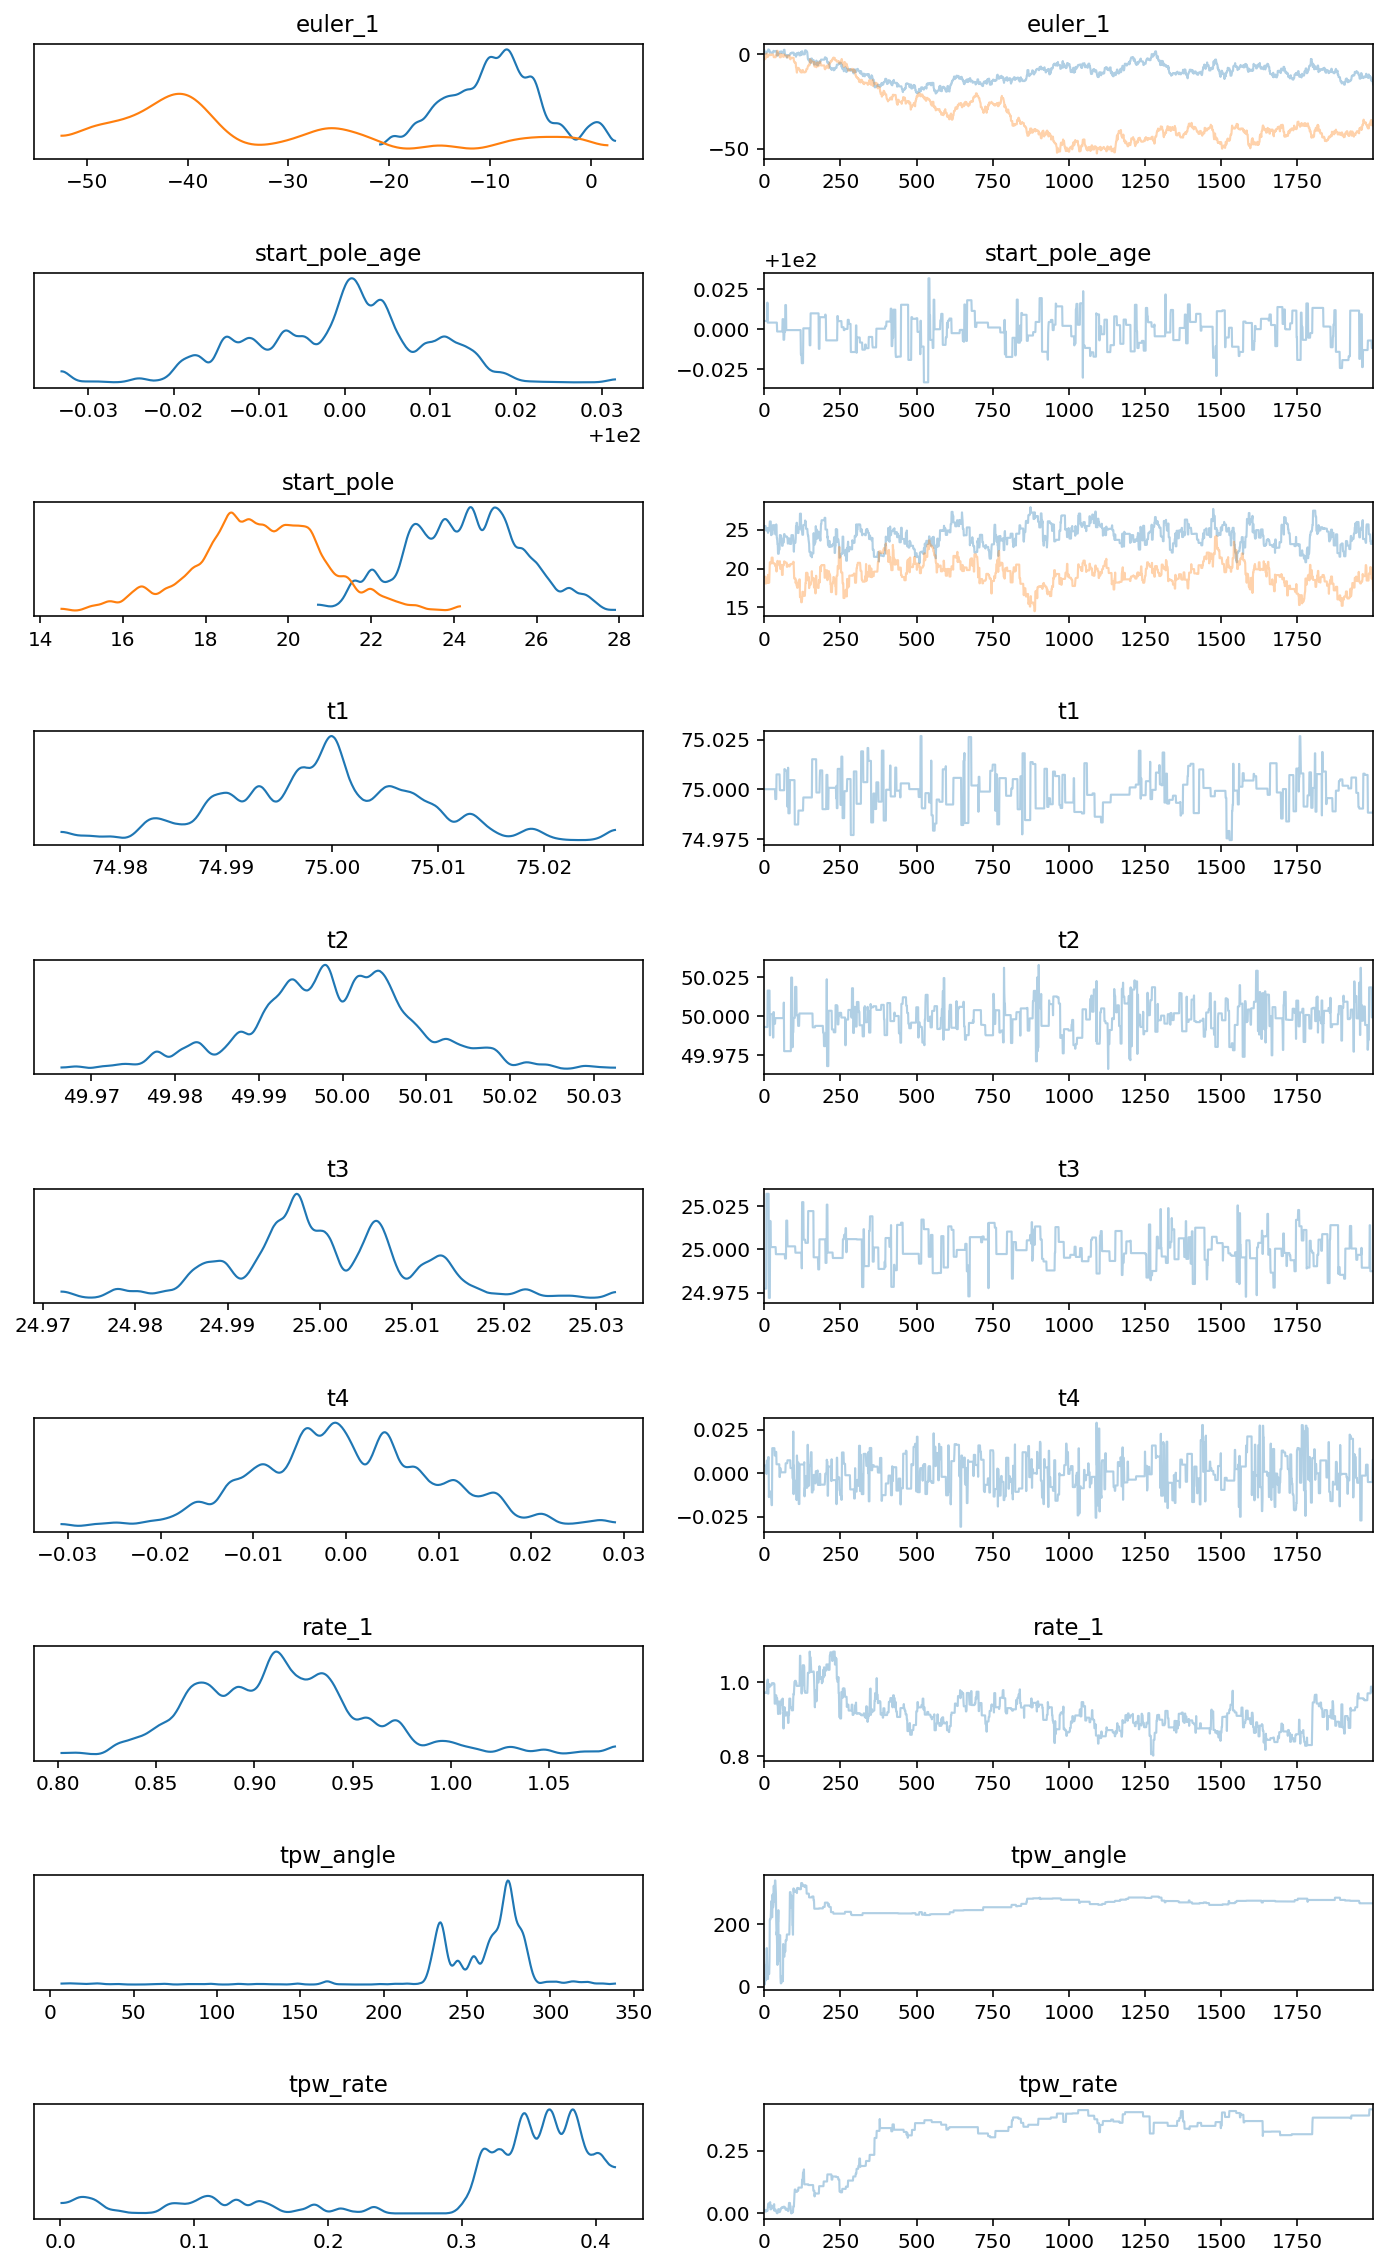

In [75]:
# plt.figure(figsize=(10, 20))
axes = pm.traceplot(trace_1e_tpw, compact=1)
plt.subplots_adjust(hspace = 1 )
# plt.savefig('code_output/1_euler_tpw_inversion_traceplot.pdf', bbox_inches='tight')

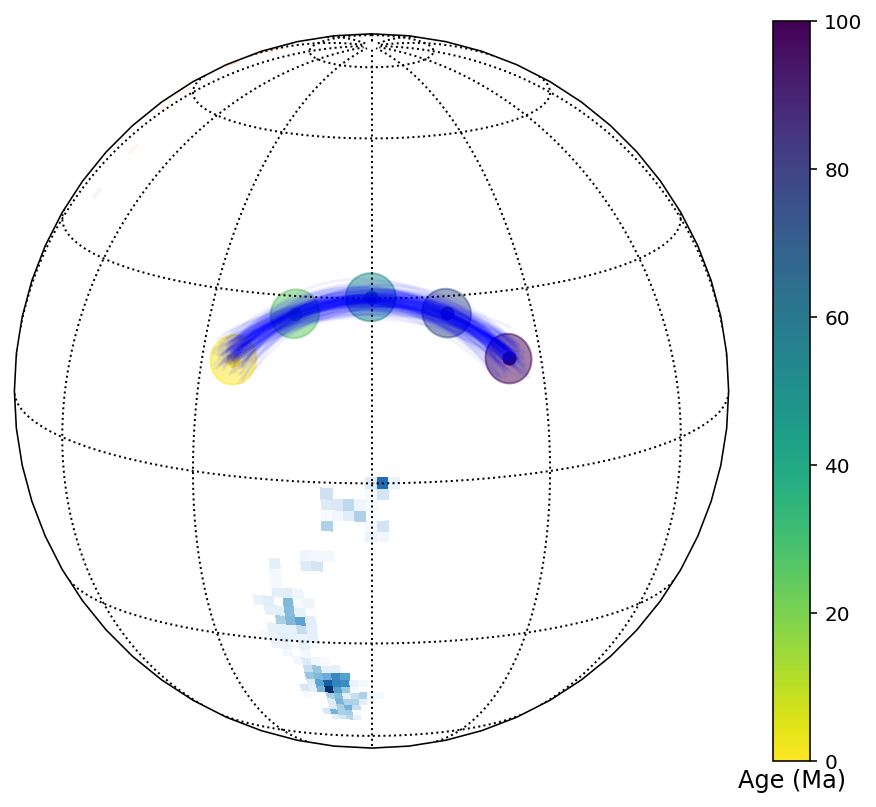

In [80]:
plot_trace_1e_tpw(trace_1e_tpw, one_euler_data[['pole_lon', 'pole_lat']].to_numpy(), one_euler_data['pole_a95'], one_euler_data['pole_age'].tolist(), 
              central_lon=0, central_lat=15, num_paths_to_plot=200, savefig = 0, figname='code_output/1_Euler_tpw_inversion_.pdf')

## only tpw inversion

In [2]:
start_age = 100
end_age = 0
number_of_poles = 5
euler_pole = [0,0]
euler_rate = 1
pole_a95 = 4
start_pole = [24, 19]

one_euler_data = generate_APWP_poles(number_of_poles, start_pole, start_age, end_age, euler_pole, euler_rate, pole_a95)
one_euler_data

pole_lon   pole_lat  pole_age  pole_a95
0   24.000000  19.000000     100.0       4.0
1   13.724333  27.231977      75.0       4.0
2  359.854182  30.256654      50.0       4.0
3  346.026499  27.112309      25.0       4.0
4  335.843743  18.796033       0.0       4.0

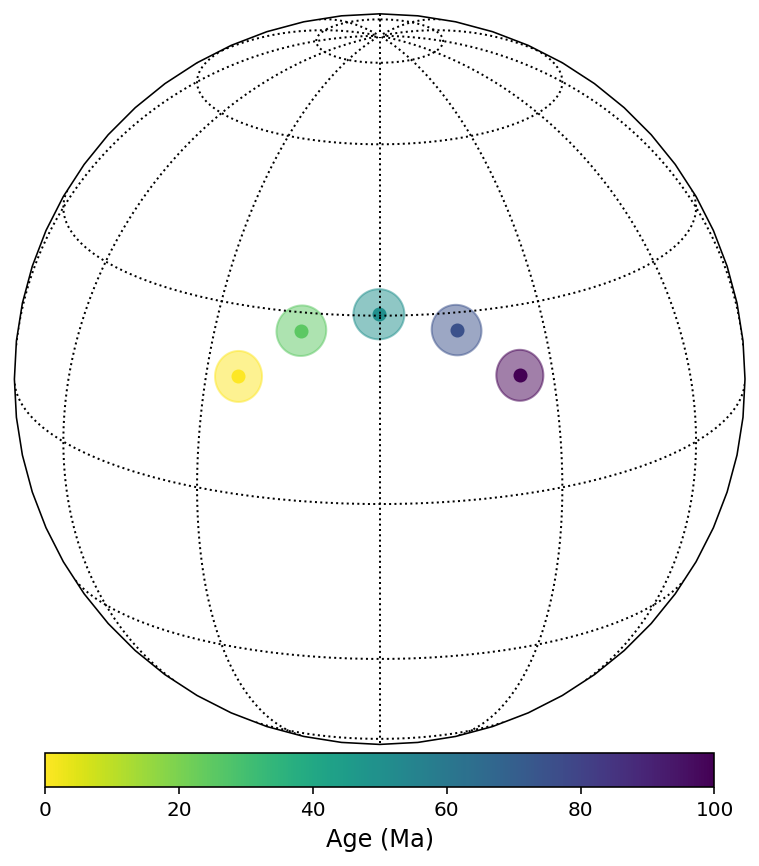

In [3]:
plot_paleomagnetic_poles(one_euler_data, central_latitude=20, add_land=0);

In [14]:
with pm.Model() as model:
    
    #set the the start age to be a tight normal distribution about the oldest pole age
    start_age = pm.Normal('start_pole_age', mu=one_euler_data['pole_age'].max(), sigma=0.01)
    print('starting pole age is: ', str(one_euler_data['pole_age'].max()))
    
    #set the start point of the path to be associated with the oldest paleomagnetic pole
    start_index = one_euler_data['pole_age'].argmax()
    start_lon_lat = [one_euler_data['pole_lon'].tolist()[start_index], one_euler_data['pole_lat'].tolist()[start_index]]
    start_k = kappa_from_two_sigma(one_euler_data['pole_a95'].tolist()[start_index])
    start = VMF('start_pole', lon_lat=start_lon_lat, 
                k = start_k, testval = np.array([1., 1.]), shape = 2)
    print('starting pole lon/lat:', start_lon_lat, 'starting pole k: ',start_k)
    
    tpw_angle = pm.Uniform('tpw_angle', 0., 360.) 
    tpw_rate = pm.Uniform('tpw_rate', 0., 4.) 
    
    #create the Fisher distributions associated with the observed pole positions 
    for i in range(one_euler_data.shape[0]):
        age = pm.Normal('t'+str(i), mu=one_euler_data['pole_age'][i], sigma=0.01)
        print('pole '+str(i)+' age: ',one_euler_data['pole_age'][i])
        
        lon_lat = pole_position_tpw(start, tpw_angle, tpw_rate, start_age, age)

        observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(one_euler_data['pole_a95'].tolist()[i]), 
                            observed=[one_euler_data['pole_lon'].tolist()[i], one_euler_data['pole_lat'].tolist()[i]])
        
#     uncomment to run the model
#     trace_tpw = pm.sample(1000, step = pm.Metropolis(), chains=1, init='auto')

starting pole age is:  100.0
starting pole lon/lat: [24.0, 19.0] starting pole k:  1225.0
pole 0 age:  100.0
pole 1 age:  75.0
pole 2 age:  50.0
pole 3 age:  25.0
pole 4 age:  0.0


Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [t4]
>Metropolis: [t3]
>Metropolis: [t2]
>Metropolis: [t1]
>Metropolis: [t0]
>Metropolis: [tpw_rate]
>Metropolis: [tpw_angle]
>Metropolis: [start_pole]
>Metropolis: [start_pole_age]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 98 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [62]:
pm.save_trace(trace_tpw, 'code_output/tpw_trace', overwrite=1)

'code_output/tpw_trace'

In [63]:
trace_tpw_saved = pm.load_trace('code_output/tpw_trace',model)

In [15]:
# plt.figure(figsize=(10, 20))
axes = pm.traceplot(trace_tpw, compact=1)
plt.subplots_adjust(hspace = 1 )
# plt.savefig('code_output/1_euler_tpw_inversion_traceplot.pdf', bbox_inches='tight')

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


In [18]:
plot_trace_tpw(trace_tpw, one_euler_data[['pole_lon', 'pole_lat']].to_numpy(), one_euler_data['pole_a95'], one_euler_data['pole_age'].tolist(), 
              central_lon=0, central_lat=0, num_paths_to_plot=50, savefig = 0, figname='code_output/tpw_inversion.pdf',)

In [ ]:
trace_dataframe = pm.trace_to_dataframe(trace)
trace_dataframe

In [ ]:
plot_trace_1e(trace, 150, 65, 200, 200, savefig = False, figname = '1_euler_inversion_Monster_Shift.pdf')

poles, pole_names, pole_colors = create_model(data, 1, True)